In [132]:
import matplotlib.pyplot as plt
from matplotlib import style
import pybamm
from Durdel2023_single import get_test_parameter_values, get_final_parameter_values

In [133]:

"Primary Active Material"
rho_si = 2.336 #from ref (supplementary material)
wt_si = .679 #% from ref
"Secondary Active Material"
rho_c6 = 2.255 # (C-NERGYTM KS6L)
wt_c6 = .199
"Inactive Material"
rho_cb = 2.00 #from ref
wt_cb = 0.02 # from ref
rho_lipaa = 1.2 #ref
wt_lipaa = 0.082 # ref
rho_cmc = 1.6 #ref
wt_cmc = 0.002 #ref

v_tot  = wt_si/rho_si + wt_c6/rho_c6 + wt_cb/rho_cb + wt_lipaa/rho_lipaa + wt_cmc/rho_cmc
v_si = wt_si/rho_si
v_c6 = wt_c6/rho_c6
v_im = wt_c6/rho_c6 + wt_lipaa/rho_lipaa + wt_cmc/rho_cmc

eps_si = 0.5 * v_si / v_tot #times 0.5 to account for porosity (eps_ely = 0.5)
eps_c6 = 0.5 * v_c6 / v_tot
eps_am = 0.5* (v_si + v_c6) / v_tot

cell_volume = 0.0124*0.0124*(92e-06 + 1.2e-05 + 2.6e-05 + 136e-06 +1.5e-05)

print("Volume fraction of Si: ", eps_si
      , "Volume fraction of C6: ", eps_c6, "Volume fraction of AM: ", eps_am, "cell volume: ", cell_volume)

Volume fraction of Si:  0.31697725057239584 Volume fraction of C6:  0.09623602768522001 Volume fraction of AM:  0.41321327825761583 cell volume:  4.3206559999999996e-08


In [134]:


model = pybamm.lithium_ion.DFN(
    {
     "open-circuit potential": ("current sigmoid", "current sigmoid"), #turning on voltage hysteresis for anode and cathode
     #"working electrode": "negative",
     "SEI": "none",
     "lithium plating": "none",
    }
)

model.print_parameter_info()


┌───────────────────────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Parameter                                                 │ Type of parameter                                                                                                                                                                                           │
├───────────────────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Number of electrodes connected in parallel to make a cell │ Parameter                                                                                                                             

In [135]:
param = pybamm.ParameterValues(get_final_parameter_values())

# param.update(
#     {
#         "Primary: Negative electrode active material volume fraction": 0.09623602768522001, # primary
#         "Secondary: Negative electrode active material volume fraction": 0.31697725057239584,
#         "Negative electrode porosity": 0.5,
#     }
#     )

param.update({
    "Minimum stoichiometry in negative electrode": 0.0387,
    "Maximum stoichiometry in negative electrode": 0.2960,
    "Minimum stoichiometry in positive electrode": 0.1396,
    "Maximum stoichiometry in positive electrode": 0.7954,
}, check_already_exists=False)


In [136]:
experiment = pybamm.Experiment(
    [
        (
            "Rest for 5 minutes",
            "Discharge at C/50 until 2.9 V",
            #"Rest for 5 minutes",
            "Charge at C/50 until 4.2 V",
            "Discharge at C/50 until 2.9 V",
        ),
    ],
    period="10 seconds",

)


# exp_dis = pybamm.Experiment(
#     ["Rest for 5 minutes", "Discharge at C/50 until 3.0 V"],
#     period="10 seconds",
# )


# exp_chg = pybamm.Experiment(
#     ["Rest for 5 minutes", "Charge at C/50 until 4.2 V"],
#     period="10 seconds",
# )


In [137]:
solver=pybamm.IDAKLUSolver(rtol=1e-6, atol=1e-8)

sim = pybamm.Simulation(
    model,
    parameter_values=param,
    experiment = experiment,
    #solver=pybamm.CasadiSolver(rtol=1e-3, atol=1e-3, mode='safe', return_solution_if_failed_early=True)
)
solution = sim.solve()

xn = solution["X-averaged negative particle stoichiometry"].data
xp = solution["X-averaged positive particle stoichiometry"].data
print(xn.min(), xn.max(), xp.min(), xp.max())


# sol_dis = pybamm.Simulation(model, parameter_values=param, experiment=exp_dis, solver=solver).solve()
# pybamm.plot_voltage_components(sol_dis)

# sol_chg = pybamm.Simulation(model, parameter_values=param, experiment=exp_chg, solver=solver).solve(starting_solution=sol_dis)
# pybamm.plot_voltage_components(sol_chg)

2025-08-12 14:48:59.944 - [ERROR] callbacks.on_experiment_error(233): Simulation error: Could not find consistent states: Could not find acceptable solution: solver returned NaNs or Infs


0.053723112831298804 0.30710838707809074 0.14088821941113241 0.7589000884128578


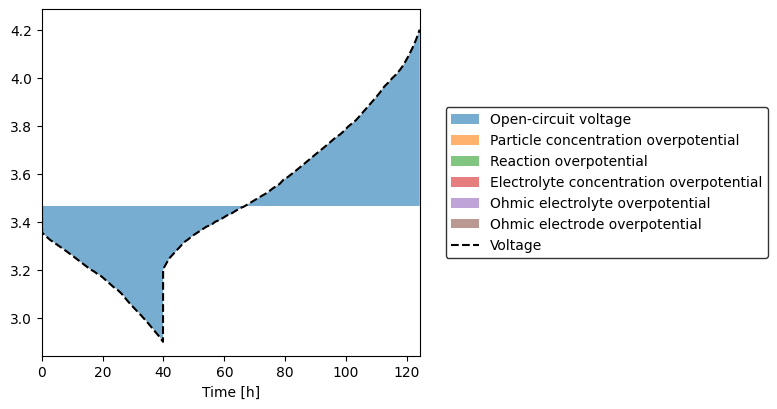

interactive(children=(FloatSlider(value=0.0, description='t', max=124.17676779848252, step=1.2417676779848252)…

In [138]:
pybamm.plot_voltage_components(solution)


sim.plot(output_variables=["Voltage [V]", 
                           "Current [A]",
                           "Negative particle surface concentration [mol.m-3]",
                           "Negative electrode potential [V]",
                           "Positive electrode potential [V]",
                           "X-averaged negative electrode open-circuit potential [V]",
                           "X-averaged positive electrode open-circuit potential [V]",
                           ])